<a href="https://colab.research.google.com/github/DaewonSeo/HongCrawler/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정치인 챗봇 만들기(beta)


---



> 해당 노트북은 '홍준표 청년의 꿈'의 '청문홍답' 게시판 데이터를 활용한 정치인 봇 만들기 예시입니다. 
* 오로지 학문적 관심과 흥미로 작성된 자료이며, 어떠한 정치적 표현도 담고있지 않습니다.


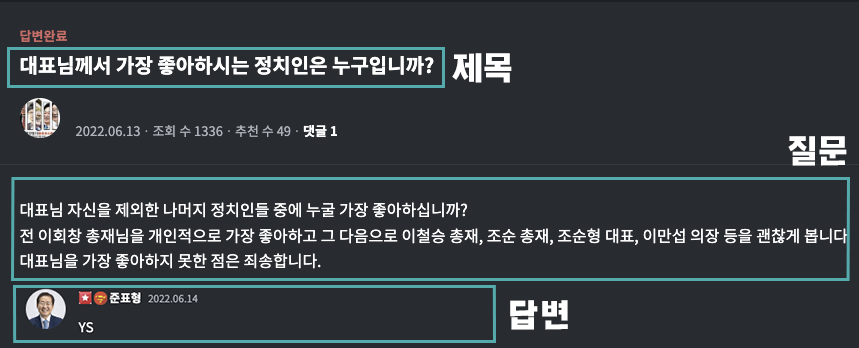


- 위 사진처럼 '청문홍답' 게시판은 유저의 질문에 대해 홍준표 의원이 단어 혹은 문장으로 답변하는 형식입니다.
- 이러한 데이터를 기반으로 '새로운 질문이 주어지면 기존의 데이터 중 유사한 질문의 답을 찾아 응답해주는 봇을 만들면 어떨까?'라는 아이디어를 가지게 되었습니다.

- 연구방법
1. 제목과 질문을 합친 데이터를 임베딩
2. 코사인 유사도 기법을 통해 임베딩된 데이터 중 유사도가 높은 데이터 값(기존 데이터 질문 내용) 추출
3. 해당 데이터(유저 질문)의 응답(홍준표 답변)을 챗봇의 응답으로 리턴
- 활용모델 : [Bert 한국어 임베딩 모델](https://huggingface.co/jhgan/ko-sroberta-multitask)

- 예시
1. 챗봇에게 '대구시에 가장 필요한 것은?' 질문
2. 기존 임베딩 데이터 중 질문과 가장 유사한 질문-답변 데이터 추출
 > 질문 : 대구시장되신다면 어떤걸 제일 하고싶은가요?? 대구가 지금 일자리가 시급한것으로 아는데 준표형이 계획하신 일자리 부흥 방법이 있을까요?? 우선 기업유치를 하는것이 좋은데 대한민국 시장이 그럴권한이 많지않은 상태라 걱정입니다
 >> 답변 : 통합신공항을기반으로 기업유치
3. 해당 데이터의 답변을 챗봇의 응답으로 리턴

* 데이터 출처 : [홍준표 청년의 꿈](https://theyouthdream.com/qna/category/273)
* 크롤러 코드 : [깃허브](https://github.com/DaewonSeo/HongCrawler)


참고자료
- https://acdongpgm.tistory.com/224
- https://wikidocs.net/157970
- https://www.youtube.com/watch?v=VVArHrsxrYU


## 1. 라이브러리 설치 및 불러오기

In [ ]:
!pip install sentence_transformers sklearn

In [4]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## 2. BERT 모델을 활용한 문장 벡터화


In [ ]:
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [6]:
sentences = ['안녕하세요', '정치인 봇입니다.']

In [7]:
embeddings = model.encode(sentences)

In [8]:
print(embeddings)

[[-0.17859323 -0.5612936   0.44627675 ...  0.50002635  0.43289614
  -0.7486528 ]
 [ 0.20583524 -0.03419176  0.9628432  ...  0.6242111  -0.6727589
  -0.44614938]]


##3. 구글 드라이브 마운트

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [10]:
DATA_PATH = '/gdrive/MyDrive/chatbot/'

##4. 데이터 정제
1. answer 컬럼의 Nan값 제거
 

In [12]:
df = pd.read_csv(DATA_PATH + 'dreamofyouth.csv', sep=',')

In [13]:
df = df[~df['answer'].isna()]

2. 제목과 질문을 합쳐 'Q', 답변을 'A'컬럼으로 재정의
- 게시판의 대부분 글 구성자체가 제목과 글을 합쳐야 전체 문장이 완성되므로, title과 question을 합칩니다.

In [19]:
df = df.copy()
df['Q'] = df['title'] + ' ' +df['question']
df['A'] = df['answer']

3. 필요한 컬럼(id, Q, A)만을 새로운 데이터프레임으로 정의




In [20]:
clean_df = df[['id', 'Q', 'A']]

In [18]:
from tqdm import tqdm
tqdm.pandas()

4. 저장한 bert 모델을 통해 질문 컬럼 전체를 임베딩


In [21]:
clean_df['embedding'] = pd.Series([[]] * len(clean_df))
clean_df = clean_df[~clean_df['embedding'].isna()]
clean_df['embedding'] = clean_df['Q'].progress_map(lambda x: list(model.encode(str(x))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 5326/5326 [01:16<00:00, 69.48it/s]


In [ ]:
clean_df.to_csv('clean_df_new.csv', index=False)

##5. 챗봇 테스트

In [41]:
def chatbot(text):
    embedding = model.encode(text)
    clean_df['similarity'] = clean_df['embedding'].map(lambda x: cosine_similarity([embedding], [x]).squeeze())
    return clean_df.loc[clean_df['similarity'].idxmax()]

In [58]:
text = '대구시에 가장 필요한 것은?' # 질문 입력
print(f"유저 : {text}")
response = chatbot(text)
print(f"챗봇 : {response['A']}")

유저 : 대구시에 가장 필요한 것은?
챗봇 : 통합신공항을기반으로 기업유치


### 추가 정보

In [59]:
print(f"매칭 질문: {response['Q']} \n유사도: {response['similarity']}")

매칭 질문: 대구시장되신다면 어떤걸 제일 하고싶은가요?? 대구가 지금 일자리가 시급한것으로 아는데 준표형이 계획하신 일자리 부흥 방법이 있을까요?? 우선 기업유치를 하는것이 좋은데 대한민국 시장이 그럴권한이 많지않은 상태라 걱정입니다 
유사도: 0.6776381731033325
